# LSXPS x FINK

In [1]:
import pandas as pd
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import swifttools.ukssdc.data.SXPS as uds

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

### Download the LSXPS Catalog

In [2]:
sources_data = uds.getFullTable(table='sources',
                        returnData=True,
                        saveData=False,
                        silent=False,
                        verbose=True)

Uploading data to https://www.swift.ac.uk/API/main.php
Returned keys: dict_keys(['OK', 'URL', 'FILE', 'APIVersion'])
Checking returned data for required content.
Saving file `/tmp/tmp9o1711cy/LSXPS_Sources.csv`
Removing downloaded file /tmp/tmp9o1711cy/LSXPS_Sources.csv


### Load the cross-match data

The cross-match data have been performed with Spark between all the available ZTF data in the Fink database and the LSXPS catalog version of the 10 November 2022. 
The ZTF data are the database snapshot of the 10 November 2022. As of 10/11/2022, there are 107,017,121 alerts available.

The ZTF alerts have been associated with a sources from LSXPS using the Err90 column given the X-ray detection error box in arcsecond.

Cross-match algorithm:
* Take all ZTF data
* Remove duplicates objectId to get only the objects and not all the alerts
* Take all LSXPS data 
* Compute healpix_column for both ZTF and LSXPS data (NSIDE = 1024, pixel_size = 3.44 arcmin)
* Join both dataframe based on the healpix column
* Refine the associations by using the Err90 column
    * separation(ztf_coordinates, lsxps_coordinates) < Err90
* Return the associations

In [13]:
ztf_x_lsxps = pd.read_parquet("../data/crossmatch/ztf_x_lsxps.parquet")

nb_unique_object = len(np.unique(ztf_x_lsxps["objectId"]))

nb_unique_objects_in_Fink = 27965535

msg = """
---
Total: {} sources
Fraction of ZTF sources: {:.1f}%
Fraction of SWIFT X-ray sources: {:.1f}%
""".format(
    nb_unique_object,  
    nb_unique_object/nb_unique_objects_in_Fink*100,
    nb_unique_object/len(sources_data)*100
)

print(msg)


---
Total: 25356 sources
Fraction of ZTF sources: 0.1%
Fraction of SWIFT X-ray sources: 8.9%



In [14]:
ztf_x_lsxps\
    .drop_duplicates("objectId")\
    .groupby('fink_class')\
    .count()\
    .sort_values('objectId', ascending=False)[['objectId']]

,objectId
fink_class,
Unknown,13167
QSO,3754
Seyfert_1,1641
Star,805
Solar System MPC,798
...,...
LP*_Candidate,1
IR,1
Symb*_Candidate,1


## Sky location

Crappy script to look at the sky distribution...

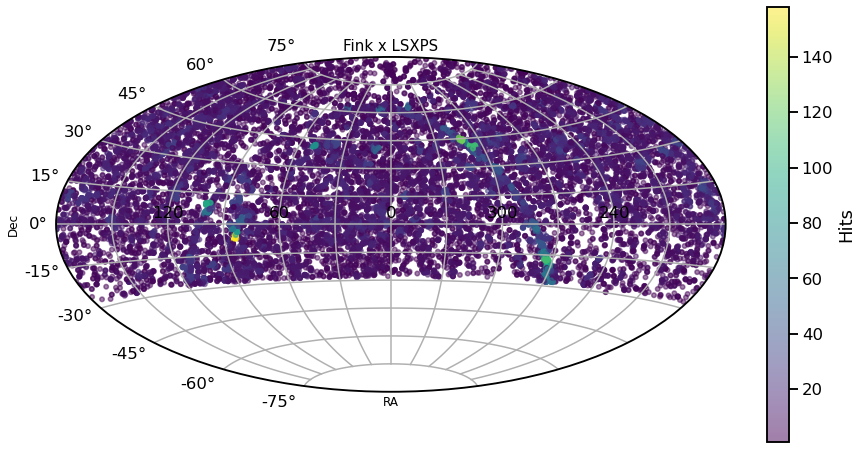

In [19]:
from script.plot import get_ppix, plot_mwd

unique_ztf_sources = ztf_x_lsxps.drop_duplicates("objectId")

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='aitoff')

ppixs = get_ppix(unique_ztf_sources, 1024)
plot_mwd(
    fig,
    unique_ztf_sources['ra'].values, 
    unique_ztf_sources['dec'].values, 
    ppixs, 
    ax=ax, 
    title='Fink x LSXPS', 
    cb_title='Hits',
    alpha=0.5,
    org=0
)

### Alerts Rate per day

In [29]:
ztf_x_lsxps["jd_day"] = ztf_x_lsxps["jd"].astype(int)
alert_per_day = ztf_x_lsxps.groupby("jd_day").count()

msg = """
Alerts Rate for LSXPS per day

Mean : {:.1f} alerts/day ± {:.1f}
""".format(alert_per_day["objectId"].mean(), alert_per_day["objectId"].std())

print(msg)


Alerts Rate for LSXPS per day

Mean : 1325.0 alerts/day ± 703.5



### MultiWavelength LightCurves